<img src = "../Docs/img/MecatronLogoPreto.png" style="float: right;" width = "80px"><img/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Análise de Dados

- Temos como objetivo final a interpretação dos dados $RAW$ oriundos do nosso sistema formado pelo AtTiny85 + MPU6050 em quantidades de passos do usuário. 
- Para facilitar o desenvolvimento e o entendimento, iremos dividir esse processos em $X$ etapas:

1. $\underline{Captação \ dos\  dados} \rightarrow$ Referente ao processo de parse o log file extraido do App de Bluetooth Low Energy; 

2. $\underline{Transformação \ RAW \iff Posição} \rightarrow$ Referente ao processo de transformar os dados crus do MPU6050 em dados posicionais (&i.e& Aceleração gravitacional $(m/s^2)$ e Velocidade Angular)

3. $\underline{Identificação\ de\ Passos\ pelo\ método\ de\ Gauss} \rightarrow$ Referente ao processo de aplicação do filtro de Gauss para retirada de barulho do sinal digital e aplicação do algoritmo de identificação de pontos máximos e mínimos para contagem de passos. 

## Captação de Dados

- Precisamos ler o arquivo LOG extraido do aplicativo BLE do IOS, que possui a seguinte extrutura: `Time Stamp`, `Package Number`: `Data 1`, `Data 2`

- Temos $dois^\star$ tipos de Data Package: 

    - Tipo 1: Com o `Package Number = 1`, `Data 1 = X Accel`, `Data 2 = Y Accel`;
    - Tipo 2: Com o `Package Number = 2`, `Data 1 = Z Accel`, `Data 2 = Z Velocity`;

$\star$ Precisamos dividir o envio de dados em 2 pacotes, pois o protocolo de BLE tem tamanho máximo de 20 char por transmição.


In [1]:
import json 

log_data = []

# Abrimos o arquivo 
with open('LogData.csv', 'r') as log_file:

    # Lemos linha por linha do arquivo
    for line in log_file:
    
        # Se for uma linha em branco, pular para próxima iteration 
        if line == '\n':
            continue 

        # Criar o dicionário que irá guardar as informações da linha parsed
        line_data = {}
        
        # A forma mais fácil de desmembrar os dados na linha é por espaços em branco, depois iremos descartar espaços desnecesários
        line = line.split(' ')
        line = list(filter(lambda n: n!='', line ))

        # Salvamos o timestap e o tipo do package
        line_data['time stamp'] = line[0]
        line_data['type'] = line[1].replace(',', '').replace(':','')
        
        # Assim como foi dito anteriormente, se o package for do tipo 1, teremos a aceleração nos eixos x e y, se for do tipo 2 no eixo z e a 
        # velocidade no eixo z
        data_1 = ''
        data_2 = ''
        if line_data['type'] == '1':
            data_1 = 'x_accel'
            data_2 = 'y_accel'
        else:
            data_1 = 'z_accel'
            data_2 = 'z_velocity'

        line_data[data_1] = line[2].replace(',','').replace('\n','')
        line_data[data_2] = line[3].replace(',','').replace('\n','')

        log_data.append(line_data)




### Plot e Interpretação

- Agora que temos os dados, podemos plotar eles para termos uma ideia melhor dos dados que estamos trabalhando

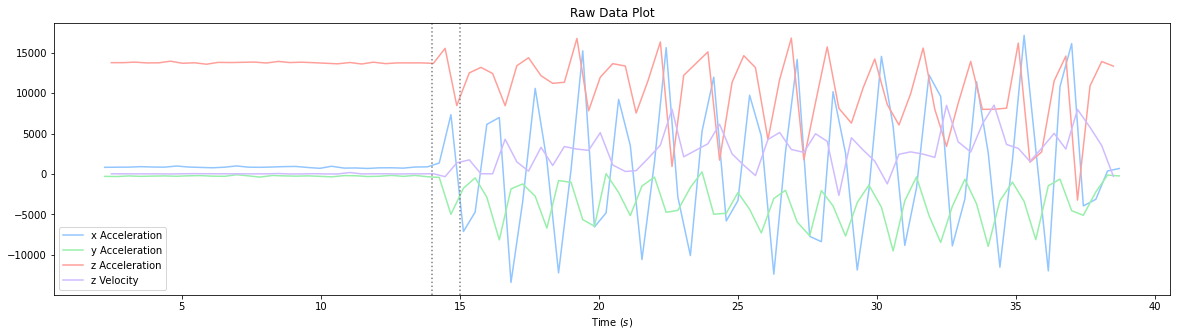

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

x_time_axis = [data_point['time stamp'] for data_point in log_data if data_point.get('x_accel') != None]

x_accel = np.array([float(data_point['x_accel']) for data_point in log_data if data_point.get('x_accel') != None])
y_accel = np.array([float(data_point['y_accel']) for data_point in log_data if data_point.get('y_accel') != None])


z_time_axis = [data_point['time stamp'] for data_point in log_data if data_point.get('z_accel') != None]
z_accel = np.array([float(data_point['z_accel']) for data_point in log_data if data_point.get('z_accel') != None])
z_velocity = np.array([float(data_point['z_velocity']) for data_point in log_data if data_point.get('z_velocity') != None])


x_time_axis = np.array([float(data.split(':')[2]) for data in x_time_axis])
z_time_axis = np.array([float(data.split(':')[2]) for data in z_time_axis])


plt.figure(figsize = (20,5))
plt.style.use('seaborn-pastel')
plt.title('Raw Data Plot')


plt.plot(x_time_axis, x_accel, label='x Acceleration')
plt.plot(x_time_axis, y_accel, label='y Acceleration')

plt.plot(z_time_axis, z_accel, label = 'z Acceleration')
plt.plot(z_time_axis, z_velocity, label = 'z Velocity')

plt.axvline(x = 14, linestyle=':', color = 'gray')
plt.axvline(x = 15, linestyle=':', color = 'gray')

plt.xlabel(r'Time ($s$)')

plt.legend()
plt.show()


### Conclusões do Plot 

- Podemos observar comportamentos similares de máximos e mínimos (como no período entre 14 e 15 segundos destacados no gráfico) dos dados nos pontos de possíveis passos, fato que será útil na hora de arquitetarmos o algorítmo de detecção de passos.

## Transformação RAW $\Rightarrow$ Posicionais

- Mesmo tendo a capacidade de determinar as dentencias e o comportamento dos dados RAW, iremos criar os algorítmos de implementação das transformações de RAW para dados "posicionais", isso é:
    - `x Acceleration` = $m/s^2$
    - `y Acceleration` = $m/s^2$
    - `z Acceleration` = $m/s^2$
    - `z Velocity` = $rad/s$


- As configurações do MPU6050 no sistema integrado com o AtTiny85 são, como especificado no [datasheet](https://inhttps://invensense.tdk.com/wp-content/uploads/2015/02/MPU-6000-Register-Map1.pdf):
    - `Acceleration Range = 2G`
    - `ACCEL_SCALE_MODIFIER_2G = 16384.0`
    - `GYRO_RANGE = 250`
    - `Gravidade = 9.80665`



In [3]:
def convert_accel_data(data:float, use_gravity:bool = False) -> float:
    
    # The modifier for the acceleration at 2g setting
    ACCEL_SCALE_MODIFIER = 16384.0
    GRAVITY = 9.80665

    data /= ACCEL_SCALE_MODIFIER
    data *= GRAVITY if use_gravity else 1

    return data


convert_accel_data = np.vectorize(convert_accel_data)

In [4]:
def convert_gyro_data(data:float) -> float:

    GYRO_RANGE = 250.0
    return (data / GYRO_RANGE)

convert_gyro_data = np.vectorize(convert_gyro_data)

### Aplicação no Data Set

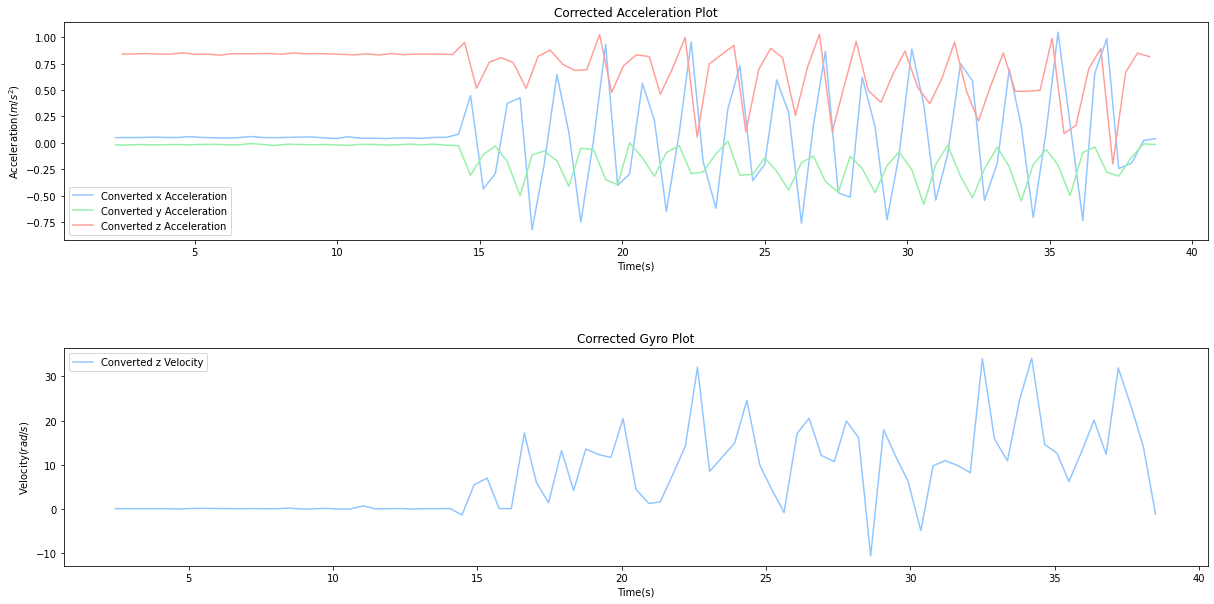

In [38]:

fig, ax = plt.subplots(2, figsize = (20.5,10), gridspec_kw={'hspace': .5})
plt.style.use('seaborn-pastel')
plt.title('Raw Data Plot')


ax[0].set_title('Corrected Acceleration Plot')
ax[0].plot(x_time_axis, convert_accel_data(x_accel), label='Converted x Acceleration')
ax[0].plot(x_time_axis, convert_accel_data(y_accel), label='Converted y Acceleration')
ax[0].plot(z_time_axis, convert_accel_data(z_accel), label = 'Converted z Acceleration')

ax[0].set(xlabel='Time(s)', ylabel='Acceleration($m/s^2$)')
ax[0].legend()


ax[1].set_title('Corrected Gyro Plot')
ax[1].plot(z_time_axis, convert_gyro_data(z_velocity), label = 'Converted z Velocity')
ax[1].set(xlabel='Time(s)', ylabel='Velocity($rad/s$)')
ax[1].legend()

plt.show()


#### Resultados Percebidos

- Podemos ver que o comportamento dos gráficos foram alterados pela transformaçõa, mas sim a ordem de grandeza (perceptível pelo intervalo nos respectivos eixos $y$ dos gráficos), o que indica o sucesso nas transformações.

## Implementação do filtro de Gauss

- Para agilizar o processo de testes e prototipagem, iremos utilizar a biblioteca scipy para fazer os cálculos numéricos necessários para a formulação do filtro de Gauss no nosso data set.

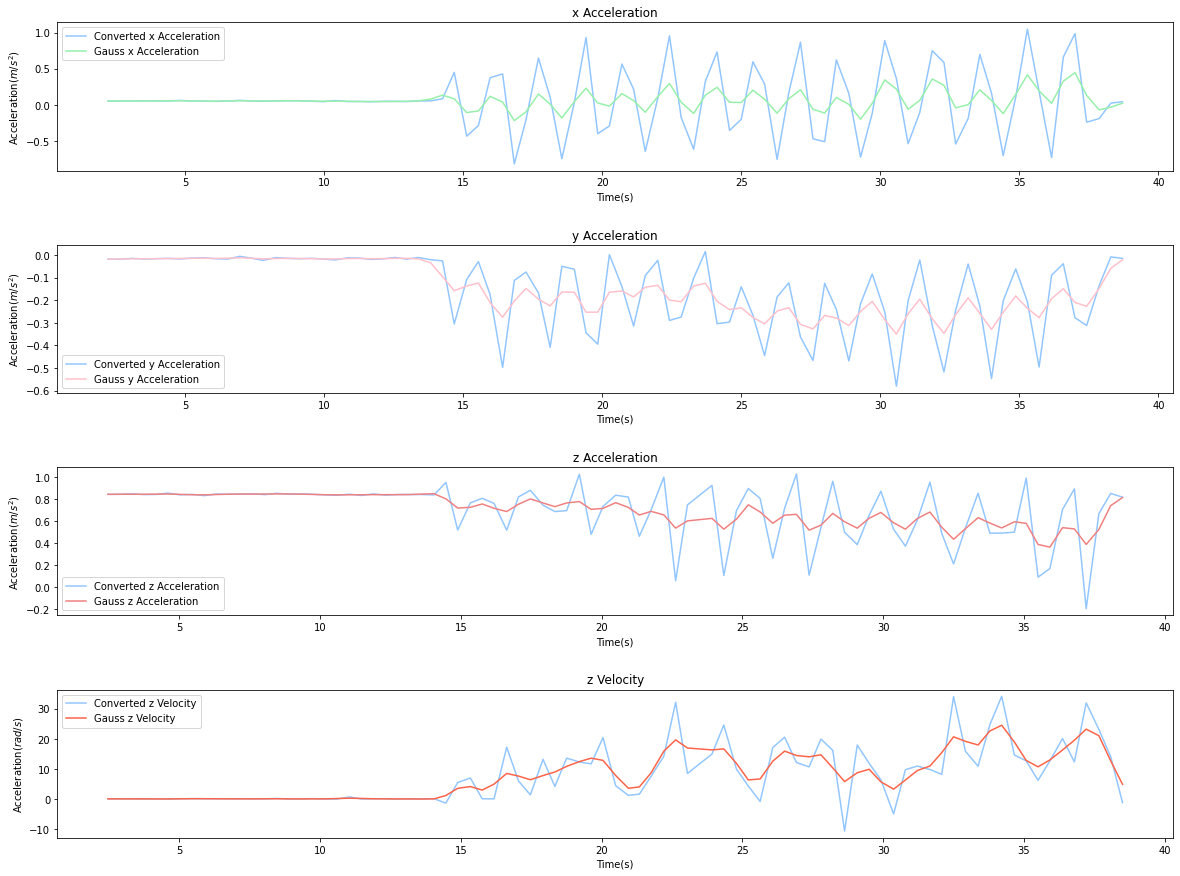

In [116]:
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

sigma_value = 1

fig, ax = plt.subplots(4, figsize = (20,15), gridspec_kw={'hspace': .5})
plt.style.use('seaborn-pastel')
plt.title('Raw Data Plot')


########################################## x Acceleration ##########################################
ax[0].set_title('x Acceleration')
ax[0].plot(x_time_axis, convert_accel_data(x_accel), label='Converted x Acceleration')
ax[0].plot(x_time_axis, gaussian_filter(convert_accel_data(x_accel), sigma=sigma_value), label='Gauss x Acceleration')

ax[0].set(xlabel='Time(s)', ylabel='Acceleration($m/s^2$)')
ax[0].legend()


########################################## y Acceleration ##########################################
ax[1].set_title('y Acceleration')
ax[1].plot(x_time_axis, convert_accel_data(y_accel), label='Converted y Acceleration')
ax[1].plot(x_time_axis, gaussian_filter(convert_accel_data(y_accel), sigma=sigma_value), 'pink',label='Gauss y Acceleration')

ax[1].set(xlabel='Time(s)', ylabel='Acceleration($m/s^2$)')
ax[1].legend()


########################################## z Acceleration ##########################################
ax[2].set_title('z Acceleration')
ax[2].plot(z_time_axis, convert_accel_data(z_accel), label='Converted z Acceleration')
ax[2].plot(z_time_axis, gaussian_filter(convert_accel_data(z_accel), sigma=sigma_value),'lightcoral' ,label='Gauss z Acceleration')

ax[2].set(xlabel='Time(s)', ylabel='Acceleration($m/s^2$)')
ax[2].legend()


########################################## z Acceleration ##########################################
ax[3].set_title('z Velocity')
ax[3].plot(z_time_axis, convert_gyro_data(z_velocity), label='Converted z Velocity')
ax[3].plot(z_time_axis, gaussian_filter(convert_gyro_data(z_velocity), sigma=sigma_value),'tomato' ,label='Gauss z Velocity')

ax[3].set(xlabel='Time(s)', ylabel='Acceleration($rad/s$)')
ax[3].legend()


plt.savefig('potato.png')